# Interactive Bayesian assesment of Confusion Matrix Metrics

If you try to predict something (protein binding, football matches, weather...) and want to assess how good your predictions work, you usually rely on metrics such as accuracy, sensitivity etc.



In [1]:
import sys
sys.path.append('/home/niklas/python_packages/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', **{'size': 22})

import pandas as pd

import ipywidgets

from bayesian_inference_confusion_matrix import ConfusionMatrixAnalyser, NewPrevalence, BetaBinomialDist
from classifier_comparison import classifier_outperformance

In [3]:
analyser = ConfusionMatrixAnalyser(pd.Series([5, 5, 5, 5], index=['TP', 'FN', 'TN', 'FP']))

In [4]:
def new_cm(TP='5', TN='5', FN='5', FP='5', 
           metric='BM', show_theta_metric=True, show_pp_metric=False, show_sample_metric=True, 
           lower_boundary=-1., upper_boundary=1.):
    cm = pd.Series({'TP': int(TP),
                    'TN': int(TN),
                    'FN': int(FN),
                    'FP': int(FP)})
    
    analyser = ConfusionMatrixAnalyser(cm)
    
    print('\n Definition of selected metric:')
    print(metric + ' = ')
    print(analyser.metrics['symbolic'][metric])
    print('\n')
    
    plt.figure(figsize=(8,6))
    analyser.plot_metric(metric, 
                         show_theta_metric, 
                         show_pp_metric,
                         show_sample_metric)
  
    integral = analyser.integrate_metric(metric, 
                                  lower_boundary, 
                                  upper_boundary)
    
    print('Probability that %s < %s < %s: %s' % (str(lower_boundary), metric, str(upper_boundary), str(integral*100)) + '%')
    
    
    hpd = analyser.calc_hpd(analyser.theta_metrics[metric])
    
    print('95% credible interval: ' + str(hpd))

Plot metrics (see [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) for a definition of the metrics)


 Definition of selected metric:
BM = 
TN/(FP + TN) + TP/(FN + TP) - 1


Probability that 0.0 < BM < 1.0: 49.86%
95% credible interval: [-0.41131635  0.41415439]


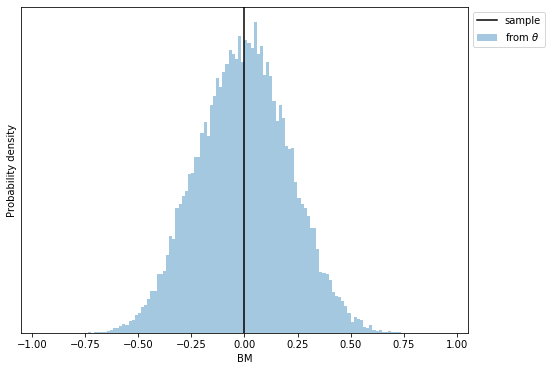

<function __main__.new_cm(TP='5', TN='5', FN='5', FP='5', metric='BM', show_theta_metric=True, show_pp_metric=False, show_sample_metric=True, lower_boundary=-1.0, upper_boundary=1.0)>

In [5]:
lower_bound_slider = ipywidgets.FloatSlider(value=0., min=-1., max=1., step=0.1)
upper_bound_slider = ipywidgets.FloatSlider(value=1., min=-1., max=1., step=0.1)

plt.figure(figsize=(10,7))
ipywidgets.interact(new_cm, metric=analyser.theta_metrics.columns, lower_boundary=lower_bound_slider, upper_boundary=upper_bound_slider)

# Sample size determination 

The necessary sample size to decrease metric uncertainty to an acceptable level can be determined for ACC, TPR, TNR, etc.

In [49]:
def calc_MU(N):
    N = int(N)
    MU = 2. / np.sqrt(N)
    formatted_string = 'For N=%2.1e, metric uncertainty should be below %2.1e in 95 of all cases.' % (N, MU)
    print(formatted_string)

In [50]:
ipywidgets.interact(calc_MU, N='100')

For N=1.0e+02, metric uncertainty should be below 2.0e-01 in 95 of all cases.


<function __main__.calc_MU(N)>

In [46]:
def calc_N(MU):
    MU = float(MU)
    N = 4. / MU**2
    formatted_string = 'If metric uncertainty should be below %2.1e in 95 percent of all cases, N must be at least %2.1e.' % (MU, N)
    print(formatted_string)

In [48]:
ipywidgets.interact(calc_N, MU='0.01')

If metric uncertainty should be below 1.0e-02 in 95 percent of all cases, N must be at least 4.0e+04.


<function __main__.calc_N(MU)>

# Compare two different classifiers

In [10]:
def compare_classifier(TP1='15', TN1='5', FN1='5', FP1='15', TP2='10', TN2='10', FN2='10', FP2='10',
           metric='BM', show_theta_metric=True, show_pp_metric=False, show_sample_metric=True, 
           lower_boundary=-1., upper_boundary=1.):
    
    cm1 = pd.Series({'TP': int(TP1),
                    'TN': int(TN1),
                    'FN': int(FN1),
                    'FP': int(FP1)})
    
    analyser1 = ConfusionMatrixAnalyser(cm1)
    
    cm2 = pd.Series({'TP': int(TP2),
                    'TN': int(TN2),
                    'FN': int(FN2),
                    'FP': int(FP2)})
    
    analyser2 = ConfusionMatrixAnalyser(cm2)
    
    plt.figure(figsize=(8,6))
    analyser1.plot_metric(metric, 
                         show_theta_metric, 
                         show_pp_metric,
                         show_sample_metric)
    analyser2.plot_metric(metric, 
                         show_theta_metric, 
                         show_pp_metric,
                         show_sample_metric)
  
    plt.legend(['usual 1', 'usual 2', 'Bayes 1', "Bayes 2"])
    
    
    outperformance = np.arange(-1., 1., 0.01)

    outperformance_probability = []

    for i in outperformance:
        curr = classifier_outperformance(analyser1.theta_metrics[metric],
                                              analyser2.theta_metrics[metric],
                                              margin=i)

        outperformance_probability.append(curr)

    outperformance_probability = pd.Series(outperformance_probability, index=outperformance)
    
    plt.figure()
    outperformance_probability.plot()
    xticks = np.arange(-1., 1.25, 0.5)
    
    plt.xticks(xticks, (xticks*100).astype(int))
    plt.axhline(0.5, c='k')
    plt.axvline(0.0, c='k')

    plt.xlabel('Outperformance lower boundary \n / percentage points')
    plt.ylabel('Probability')

In [11]:
plt.figure(figsize=(10,7))
ipywidgets.interact(compare_classifier, metric=analyser.theta_metrics.columns, lower_boundary=lower_bound_slider, upper_boundary=upper_bound_slider)

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

A Jupyter Widget

<function __main__.compare_classifier>

# Evaluate classifier for new prevalence

In [46]:
def new_prevalence(TP='5', TN='5', FN='5', FP='5', metric='BM', 
                   lower_boundary=-1., upper_boundary=1.,
                   expected_prevalence='0.5',
                   prevalence_weight='2',):
    cm = pd.Series({'TP': int(TP),
                    'TN': int(TN),
                    'FN': int(FN),
                    'FP': int(FP)})
    
    analyser = ConfusionMatrixAnalyser(cm)
    
    expected_prevalence = float(expected_prevalence)
    prevalence_weight = float(prevalence_weight)
    new_prev = BetaBinomialDist(expected_prevalence * prevalence_weight, (1-expected_prevalence) * prevalence_weight)
    analyser = NewPrevalence(analyser, new_prev)
    
    print('\n Definition of selected metric:')
    print(metric + ' = ')
    print(analyser.metrics['symbolic'][metric])
    print('\n')
    
    fig, axes = plt.subplots(nrows=2, figsize=(8,8))

    analyser.plot_metric('PREVALENCE', 
                         show_theta_metric=True, 
                         show_pp_metric=False,
                         show_sample_metric=False,
                         sel_ax=axes[0])
    
    analyser.plot_metric(metric, 
                         show_theta_metric=True, 
                         show_pp_metric=False,
                         show_sample_metric=False,
                         sel_ax=axes[1])
  
    plt.subplots_adjust(hspace=0.5)

    integral = analyser.integrate_metric(metric, 
                                  lower_boundary, 
                                  upper_boundary)
    
    print('Probability that %s < %s < %s: %s' % (str(lower_boundary), metric, str(upper_boundary), str(integral*100)) + '%')
    
    
    hpd = analyser.calc_hpd(analyser.theta_metrics[metric])
    
    print('95% credible interval: ' + str(hpd))

In [47]:
prev_step = 0.05
expected_prevalence_slider = ipywidgets.FloatSlider(value=0.5, min=0. + prev_step, max=1. - prev_step, step=prev_step)

plt.figure(figsize=(10,7))
ipywidgets.interact(new_prevalence, metric=analyser.theta_metrics.columns, lower_boundary=lower_bound_slider, upper_boundary=upper_bound_slider)

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

A Jupyter Widget

<function __main__.new_prevalence>